# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [41]:
# imports
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [42]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='week'>

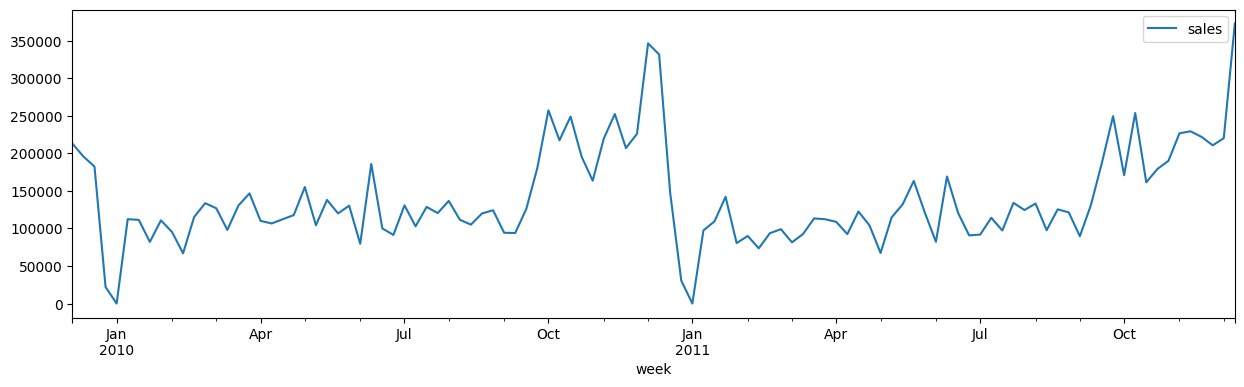

In [43]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [44]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month"
    ],
)

# Extract the datetime features
df = dtf.fit_transform(df)

# Show new variables
df.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [45]:
# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)

df = cyclicf.fit_transform(df)

df[[v for v in df.columns if "month" in v or "hour" in v]].head()

,month,month_sin,month_cos
week,,,
2009-12-06,12,-2.449294e-16,1.000000
2009-12-13,12,-2.449294e-16,1.000000
2009-12-20,12,-2.449294e-16,1.000000
2009-12-27,12,-2.449294e-16,1.000000
2010-01-03,1,5.000000e-01,0.866025


In [46]:
# Create the feature lag-1 by lagging 1 week of data.
# Add the lag features.

lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq=["1W"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

# Add the lag features.
df = lagf.fit_transform(df)

# Show new variables
df[[v for v in df.columns if "lag" in v]].head()

,sales_lag_1W
week,
2009-12-06,NaN
2009-12-13,213000.35
2009-12-20,195810.04
2009-12-27,182396.74
2010-01-03,22007.77


In [47]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf_2w = WindowFeatures(
    variables=["sales"],  # the input variables
    window="14D",  # average of 3 previous hours
    freq="7D",  # move 1 hr forward
    missing_values="ignore",
    functions=["mean", "max", "min"],
)

# Add the window features.
df = winf_2w.fit_transform(df)

# Show new variables
df[[v for v in df.columns if "window" in v]].head()

,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min
week,,,
2009-12-06,NaN,NaN,NaN
2009-12-13,213000.350,213000.35,213000.35
2009-12-20,204405.195,213000.35,195810.04
2009-12-27,189103.390,195810.04,182396.74
2010-01-03,102202.255,182396.74,22007.77


In [48]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf_4w = WindowFeatures(
    variables=["sales"],  # the input variables
    window="28D",  # average of 3 previous hours
    freq="7D",  # move 1 hr forward
    missing_values="ignore",
)

# Add the window features.
df = winf_4w.fit_transform(df)

# Show new variables
df[[v for v in df.columns if "window" in v]].head()

,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_28D_mean
week,,,,
2009-12-06,NaN,NaN,NaN,NaN
2009-12-13,213000.350,213000.35,213000.35,213000.350000
2009-12-20,204405.195,213000.35,195810.04,204405.195000
2009-12-27,189103.390,195810.04,182396.74,197069.043333
2010-01-03,102202.255,182396.74,22007.77,153303.725000


In [49]:
# Drop missing data.
df.isnull().sum()

sales                    0
month                    0
month_sin                0
month_cos                0
sales_lag_1W             1
sales_window_14D_mean    1
sales_window_14D_max     1
sales_window_14D_min     1
sales_window_28D_mean    1
dtype: int64

In [50]:
# We drop the observations with NA.

print(df.shape)

imputer = DropMissingData()
df = imputer.fit_transform(df)

print(df.shape)

(106, 9)
(105, 9)


In [51]:
df.head()

,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_28D_mean
week,,,,,,,,,
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35,213000.350,213000.35,213000.35,213000.350000
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04,204405.195,213000.35,195810.04,204405.195000
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74,189103.390,195810.04,182396.74,197069.043333
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77,102202.255,182396.74,22007.77,153303.725000
2010-01-10,112318.85,1,5.000000e-01,0.866025,0.00,11003.885,22007.77,0.00,100053.637500


In [52]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["sales"])
df = drop_ts.fit_transform(df)

df.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_28D_mean
week,,,,,,,,
2009-12-13,12,-2.449294e-16,1.000000,213000.35,213000.350,213000.35,213000.35,213000.350000
2009-12-20,12,-2.449294e-16,1.000000,195810.04,204405.195,213000.35,195810.04,204405.195000
2009-12-27,12,-2.449294e-16,1.000000,182396.74,189103.390,195810.04,182396.74,197069.043333
2010-01-03,1,5.000000e-01,0.866025,22007.77,102202.255,182396.74,22007.77,153303.725000
2010-01-10,1,5.000000e-01,0.866025,0.00,11003.885,22007.77,0.00,100053.637500


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

### Load data

In [53]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


### Feature Engineering Steps

In [54]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month"
    ],
)

In [55]:
# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)

In [56]:
# Create the feature lag-1 by lagging 1 week of data.
# Add the lag features.

lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq=["1W"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [57]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf_2w = WindowFeatures(
    variables=["sales"],  # the input variables
    window="14D",  # average of 3 previous hours
    freq="7D",  # move 1 hr forward
    missing_values="ignore",
    functions=["mean", "max", "min"],
)

In [58]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.
winf_4w = WindowFeatures(
    variables=["sales"],  # the input variables
    window="28D",  # average of 3 previous hours
    freq="7D",  # move 1 hr forward
    missing_values="ignore",
)

In [59]:
# We drop the observations with NA.
imputer = DropMissingData()

In [60]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["sales"])

### Feature Engineering Pipeline

In [61]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf_2w", winf_2w),
        ("winf_4w", winf_4w),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

### Split into train and test

In [62]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

Due to our 2W and 4W window features, we need data about sales at least 4 weeks
before the first forecasting point in the test set to create the features.

In [63]:
# The offset for the test set
# The last month of data begins on 2011-11-11, but we need 28 days prior to
# that to create the features.
pd.Timestamp("2011-11-11") - pd.offsets.Day(28)

Timestamp('2011-10-14 00:00:00')

In [64]:
# Split the data in time.

# input data
X_train = df[df.index < "2011-11-11"]
X_test = df[df.index >= pd.Timestamp("2011-11-11") - pd.offsets.Day(28)]

# target
y_train = df[df.index < "2011-11-11"]["sales"]
y_test = df[df.index >= pd.Timestamp("2011-11-11") - pd.offsets.Day(28)][
    "sales"
]

In [65]:
# Let's check that we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2011-10-16 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [66]:
# Target (in this dataset, is is the train set itself)

### Train Pipeline and Model

In [67]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_28D_mean,month_sin,month_cos
week,,,,,,,,
2009-12-13,12,213000.35,213000.350,213000.35,213000.35,213000.350000,-2.449294e-16,1.000000
2009-12-20,12,195810.04,204405.195,213000.35,195810.04,204405.195000,-2.449294e-16,1.000000
2009-12-27,12,182396.74,189103.390,195810.04,182396.74,197069.043333,-2.449294e-16,1.000000
2010-01-03,1,22007.77,102202.255,182396.74,22007.77,153303.725000,5.000000e-01,0.866025
2010-01-10,1,0.00,11003.885,22007.77,0.00,100053.637500,5.000000e-01,0.866025


In [68]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(101,)
(100,)


In [69]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

In [70]:
# Make predictions

preds = lasso.predict(X_train_t)

preds

array([209733.12458476, 200664.79080917, 199045.63001267,  26762.70089784,
        69004.11094405, 127562.81635033, 107024.82969209,  89387.30102288,
       113512.33375441,  99586.4817688 ,  89175.98599415, 118980.63590788,
       119007.50856678, 111045.88277344,  96145.14379036, 119344.53423246,
       120642.27210699,  97088.60015858, 106473.99351157, 110430.92921975,
       113976.8681008 , 128602.35703771,  92579.06596758, 123118.96737092,
       106391.16649702, 121435.86612268,  91180.0024542 , 153423.89242234,
        84704.72827454, 115654.74412424, 134873.7021263 , 113160.08004609,
       132843.76751133, 134480.41168842, 144166.63814059, 126646.39262537,
       131301.18568948, 139976.05863742, 153884.56473304, 136377.27518131,
       145818.91755036, 160055.42039804, 192767.85466821, 213069.9265921 ,
       173281.5401967 , 197354.32667282, 160699.1981259 , 175835.47240154,
       210794.84642462, 214534.30815078, 182281.51931152, 215573.84901993,
       263016.37341127, 2

Text(0.5, 1.0, 'Forecast: train set')

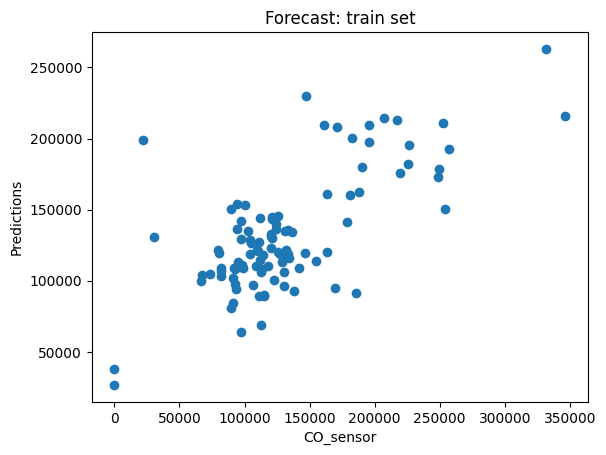

In [71]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [72]:
# The RMSE in the train set.

mean_squared_error(preds, y_train_t, squared=False)

41551.36914441597

### Evaluate Model

In [73]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,sales_lag_1W,sales_window_14D_mean,sales_window_14D_max,sales_window_14D_min,sales_window_28D_mean,month_sin,month_cos
week,,,,,,,,
2011-10-23,10,161438.54,161438.540,161438.54,161438.54,161438.540000,-0.866025,0.500000
2011-10-30,10,179106.07,170272.305,179106.07,161438.54,170272.305000,-0.866025,0.500000
2011-11-06,11,190034.20,184570.135,190034.20,179106.07,176859.603333,-0.500000,0.866025
2011-11-13,11,226770.53,208402.365,226770.53,190034.20,189337.335000,-0.500000,0.866025
2011-11-20,11,229378.01,228074.270,229378.01,226770.53,206322.202500,-0.500000,0.866025


In [74]:
# Note that the prior 24 hr of information
# dissapeared from our test set (they had null data).

# Our dataset contains the first forecasting point
# as expected.

X_test_t.index.min(), X_test_t.index.max()

(Timestamp('2011-10-23 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [75]:
# Make predictions.

preds = lasso.predict(X_test_t)

preds[0:10]

array([174359.37938622, 181502.84978363, 197059.70263808, 210298.92765686,
       203059.52444597, 197433.10179846, 204918.53276312, 212763.13524826])

In [76]:
print(y_test.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test.loc[X_test_t.index]

print(y_test_t.shape)

(9,)
(8,)


Text(0.5, 1.0, 'Forecast: test set')

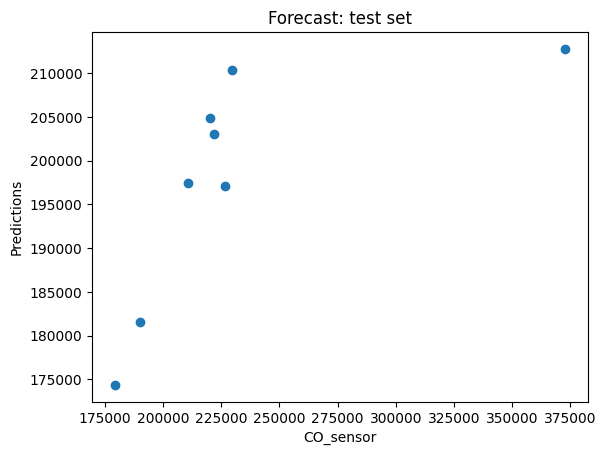

In [77]:
# Plot the predictions vs the truth.

plt.scatter(y_test_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [78]:
# RMSE in test set

mean_squared_error(preds, y_test_t, squared=False)

58912.657176804714